In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

In [0]:
class SmallerVGGNet:
	@staticmethod
	def build(width, height, depth, classes, finalAct="softmax"):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1
    
    # CONV => RELU => POOL
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))
    
    # (CONV => RELU) * 2 => POOL
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
    
    # first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(1024))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
 
		# use a *softmax* activation for single-label classification
		# and *sigmoid* activation for multi-label classification
		model.add(Dense(classes))
		model.add(Activation(finalAct))
 
		# return the constructed network architecture
		return model

In [0]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
 
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
#from pyimagesearch.smallervggnet import SmallerVGGNet
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

In [0]:
dataset = "/content/gdrive/My Drive/data_clothes/"
model = "/content/gdrive/My Drive"
labelbin = "/content/gdrive/My Drive"
plot = "/content/gdrive/My Drive"

In [0]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 75
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)

In [0]:
# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
#imagePaths = sorted(list(paths.list_images(args["dataset"])))
imagePaths = sorted(list(paths.list_images(dataset)))
random.seed(42)
random.shuffle(imagePaths)
 
# initialize the data and labels
data = []
labels = []
print("done")

[INFO] loading images...
done


In [0]:
# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	image = img_to_array(image)
	data.append(image)
 
	# extract set of class labels from the image path and update the
	# labels list
	l = label = imagePath.split(os.path.sep)[-2].split("_")
	labels.append(l)

In [0]:
print(len(imagePaths))
#for i in range(len(imagePaths)):
#  print(data[i].shape)
#print(data)

10760


In [0]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
	len(imagePaths), data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 10760 images (2324.16MB)


In [0]:
# binarize the labels using scikit-learn's special multi-label
# binarizer implementation
print("[INFO] class labels:")
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
 
# loop over each of the possible class labels and show them
for (i, label) in enumerate(mlb.classes_):
	print("{}. {}".format(i + 1, label))

[INFO] class labels:
1. Tshirt
2. black
3. blue
4. coat
5. gray
6. green
7. red
8. shirt
9. white
10. yellow


In [0]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.2, random_state=42)
 
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

In [0]:
plt.imshow(trainX[10])
print(trainX[10].shape)
print(trainY[10])

(96, 96, 3)
[1 1 0 0 0 0 0 0 0 0]


In [0]:
# initialize the model using a sigmoid activation as the final layer
# in the network so we can perform multi-label classification
print("[INFO] compiling model...")
model = SmallerVGGNet.build(
	width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
	depth=IMAGE_DIMS[2], classes=len(mlb.classes_),
	finalAct="sigmoid")
 
# initialize the optimizer
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

[INFO] compiling model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#print(model.summary())

In [0]:
# compile the model using binary cross-entropy rather than
# categorical cross-entropy -- this may seem counterintuitive for
# multi-label classification, but keep in mind that the goal here
# is to treat each output label as an independent Bernoulli
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
 
# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)

[INFO] training network...
Instructions for updating:
Use tf.cast instead.
Epoch 1/75
269/269 [==============================] - 26s 98ms/step - loss: 0.3400 - acc: 0.8514 - val_loss: 0.2019 - val_acc: 0.9170
Epoch 2/75
269/269 [==============================] - 20s 74ms/step - loss: 0.2228 - acc: 0.9030 - val_loss: 0.4322 - val_acc: 0.8925
Epoch 3/75
269/269 [==============================] - 20s 73ms/step - loss: 0.2035 - acc: 0.9112 - val_loss: 0.4378 - val_acc: 0.8757
Epoch 4/75
269/269 [==============================] - 20s 73ms/step - loss: 0.1830 - acc: 0.9210 - val_loss: 0.1374 - val_acc: 0.9421
Epoch 5/75
269/269 [==============================] - 21s 76ms/step - loss: 0.1651 - acc: 0.9291 - val_loss: 0.1457 - val_acc: 0.9396
Epoch 6/75
269/269 [==============================] - 20s 74ms/step - loss: 0.1595 - acc: 0.9322 - val_loss: 0.1404 - val_acc: 0.9441
Epoch 7/75
269/269 [==============================] - 20s 73ms/step - loss: 0.1536 - acc: 0.9350 - val_loss: 0.1530 - val

In [0]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig("plot")

In [0]:
# save the model to disk
print("[INFO] serializing network...")
model.save("/content/gdrive/My Drive/clothes.h5")

# save the multi-label binarizer to disk
print("[INFO] serializing label binarizer...")
f = open("/content/gdrive/My Drive/labelbin.pickle", "wb")
f.write(pickle.dumps(mlb))
f.close()

[INFO] serializing network...
[INFO] serializing label binarizer...


**---Load image to test model clothes.h5---**

In [4]:
# import the necessary packages
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import imutils
import pickle
import cv2
import os
import matplotlib.pyplot as plt
import urllib.request
import requests
from PIL import Image
from skimage import io

Using TensorFlow backend.


In [5]:
# load the trained convolutional neural network and the multi-label
# binarizer
print("[INFO] loading network...")
model = load_model("/content/gdrive/My Drive/Train_clothes/clothes.h5")
mlb = pickle.loads(open("/content/gdrive/My Drive/Train_clothes/labelbin.pickle", "rb").read())

[INFO] loading network...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator MultiLabelBinarizer from version 0.21.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


[INFO] classifying image...
blue: 99.91%
Tshirt: 93.79%


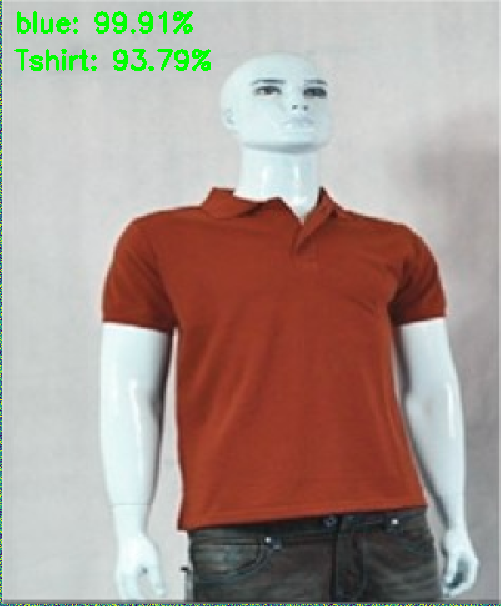

In [6]:
# load the image from url
#url = "https://img.zanado.com/media/catalog/product/cache/all/thumbnail/255x298/7b8fef0172c2eb72dd8fd366c999954c/1/_/ao_so_mi_nam_tay_dai_lich_lam_akuba_nt8872_1f1b.jpg"
#image = io.imread(url)
#image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

image = cv2.imread("Facebook - Google Chrome.jpg")
output = imutils.resize(image, width=400)
 
# pre-process the image for classification
image = cv2.resize(image, (96, 96))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

# classify the input image then find the indexes of the two class
# labels with the *largest* probability
print("[INFO] classifying image...")
proba = model.predict(image)[0]
idxs = np.argsort(proba)[::-1][:2]

# loop over the indexes of the high confidence class labels
for (i, j) in enumerate(idxs):
	# build the label and draw the label on the image
  label = "{}: {:.2f}%".format(mlb.classes_[j], proba[j] * 100)
  print(label)
  cv2.putText(output, label, (10, (i * 30) + 25), 
		cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# imshow on window
#cv2.namedWindow('image',cv2.WINDOW_NORMAL)
#cv2.imshow('image',output)
#cv2.waitKey(0)

# DPI, here, has _nothing_ to do with your screen's DPI.
dpi = 4.0
xpixels, ypixels = 800, 800

fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
fig.figimage(np.random.random((xpixels, ypixels)))

plt.axis('off')
plt.imshow(output)
plt.show()
  
# show the probabilities for each of the individual labels
#for (label, p) in zip(mlb.classes_, proba):
#  print("{}: {:.2f}%".format(label, p * 100))